## CPR Waveform Segmentation - PostDoc Application

**Project Goal:** Develop a machine learning model to accurately identify diastolic and systolic points within arterial waveforms obtained during both chest compressions and normal heartbeats.

**Background:** Analyzing these waveforms is crucial for monitoring CPR effectiveness. Standard peak detection methods can be unreliable during compressions, necessitating a more robust approach.

**Data:** This notebook utilizes a dataset of 6,800 labeled waveform segments.

Let's first load the data

In [1]:
import numpy as np

try:
    # Attempt to load the data
    data = np.load('data/sample_data.npy')

    # Print the shape of the loaded data to verify it's loaded correctly
    print("Data loaded successfully!")
    print("Shape of the loaded data:", data.shape)

    # You can now work with the 'data' variable. For example, print the first few elements:
    # print(data[:5])

except FileNotFoundError:
    print("Error: 'sample_data.npy' not found. Please make sure the file exists in the current directory.")
except Exception as e:
    print(f"An error occurred while loading the data: {e}")

Data loaded successfully!
Shape of the loaded data: (2, 6800, 400)


In [2]:
input_data = data[0,:,:]
output_data = data[1,:,:].astype(int)
signal_freq = 200  # Hz
CLASS_LABEL = {
    0: "Nothing",
    1: "Diastolic (compression)",
    2: "Systolic (compression)",
    3: "Diastolic (normal)",
    4: "Systolic (normal)",
}

First lets split up Chest compression and Normal heartbeat data so we can view some examples

In [3]:
import numpy as np
import pandas as pd

# Building database for chest compression
idx_cc = []         
for i in range(output_data.shape[0]):
    if np.any(output_data[i, :] == 1) or np.any(output_data[i, :] == 2):
        idx_cc.append(i)
# Building database for normal heartbeat
idx_nh = []
for i in range(output_data.shape[0]):
    if np.any(output_data[i, :] == 3) or np.any(output_data[i, :] == 4):
        idx_nh.append(i)
#Robustness check
overlap = set(idx_cc) & set(idx_nh)
if overlap:
    print(f"Overlap found! {len(overlap)} common indices.")
    print(sorted(list(overlap))[:20], "...")  # preview first 20
else:
    print("✅ No overlapping indices.")



Overlap found! 6 common indices.
[1439, 3220, 3349, 4031, 5367, 5558] ...


Now visualizing for Chest Compressions

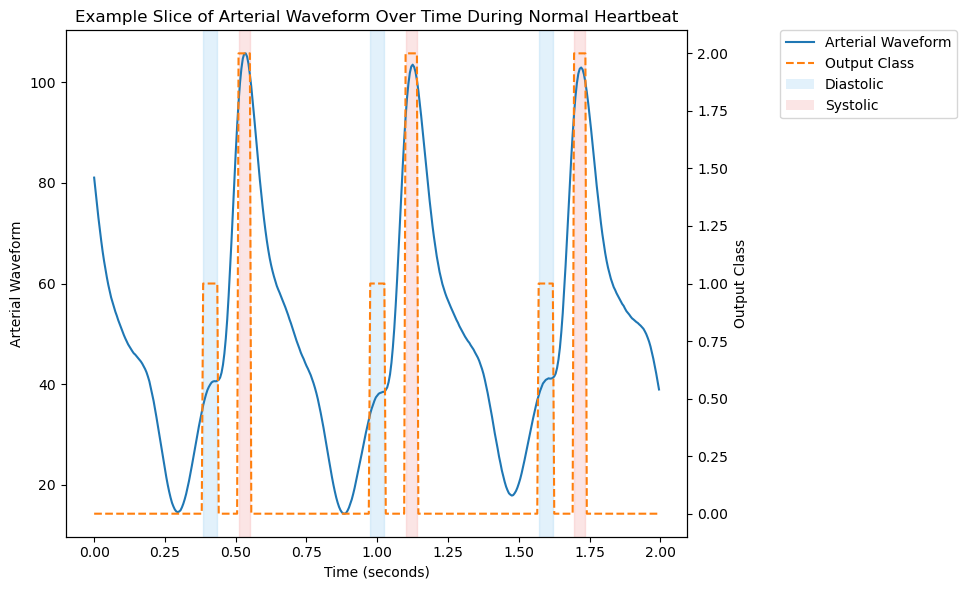

(<Figure size 1000x600 with 2 Axes>,
 <Axes: title={'center': 'Example Slice of Arterial Waveform Over Time During Normal Heartbeat'}, xlabel='Time (seconds)', ylabel='Arterial Waveform'>)

In [4]:
from my_plotting_fun import plot_arterial_waveform
plot_arterial_waveform(input_data=input_data[idx_cc[0],:], output_data=output_data[idx_cc[0],:],class_labels={1: "Diastolic", 2: "Systolic"},
                       class_colors={1: "#8EC9F0", 2: "#F29A9A"})


Now visualizing for Normal Heartbeat

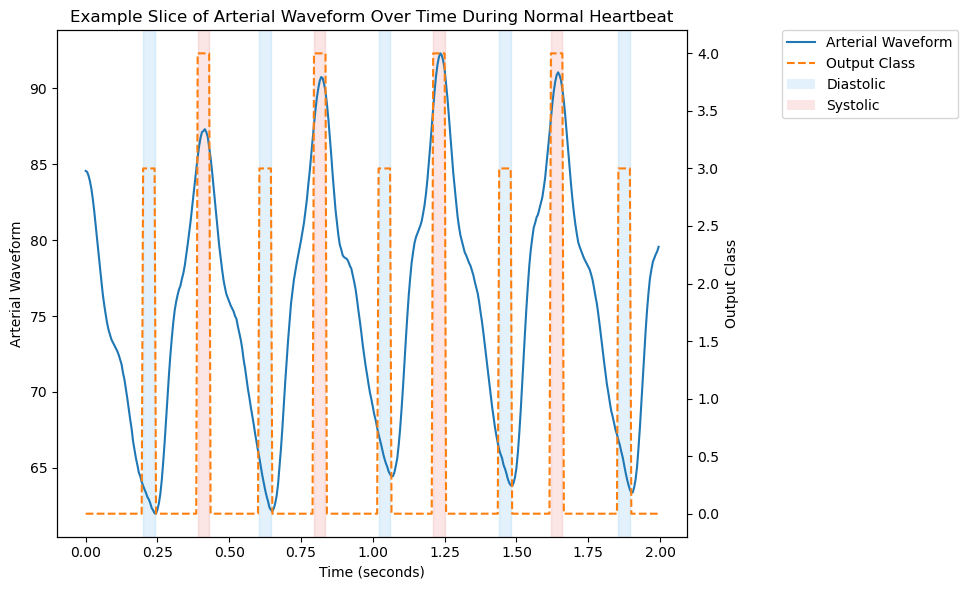

(<Figure size 1000x600 with 2 Axes>,
 <Axes: title={'center': 'Example Slice of Arterial Waveform Over Time During Normal Heartbeat'}, xlabel='Time (seconds)', ylabel='Arterial Waveform'>)

In [5]:
from my_plotting_fun import plot_arterial_waveform
plot_arterial_waveform(input_data=input_data[idx_nh[0],:], output_data=output_data[idx_nh[0],:],class_labels={3: "Diastolic", 4: "Systolic"},
                       class_colors={3: "#8EC9F0", 4: "#F29A9A"})

## Upstroke & Downstroke Time Distributions (CC vs NH)

Below we compare the **upstroke** (i.e. diastolic → systolic) and **downstroke** (i.e. systolic → next diastolic) time intervals under the **Chest-Compression (CC)** condition vs the **Normal Heartbeat (NH)** condition.

- The **upstroke distribution** reflects how long it takes for the signal to rise from the diastolic trough to the systolic peak in each beat.  
- The **downstroke distribution** shows how long it takes from the systolic peak back to the following diastolic trough.  
- We will visualize each with **histograms + KDE overlays** and **violin/box plots** to highlight differences in shape, central tendency, spread, and outliers between CC vs NH.  
- In addition, we’ll compute summary metrics (mean, median, IQR) for each group and stroke type to support quantitative comparison.


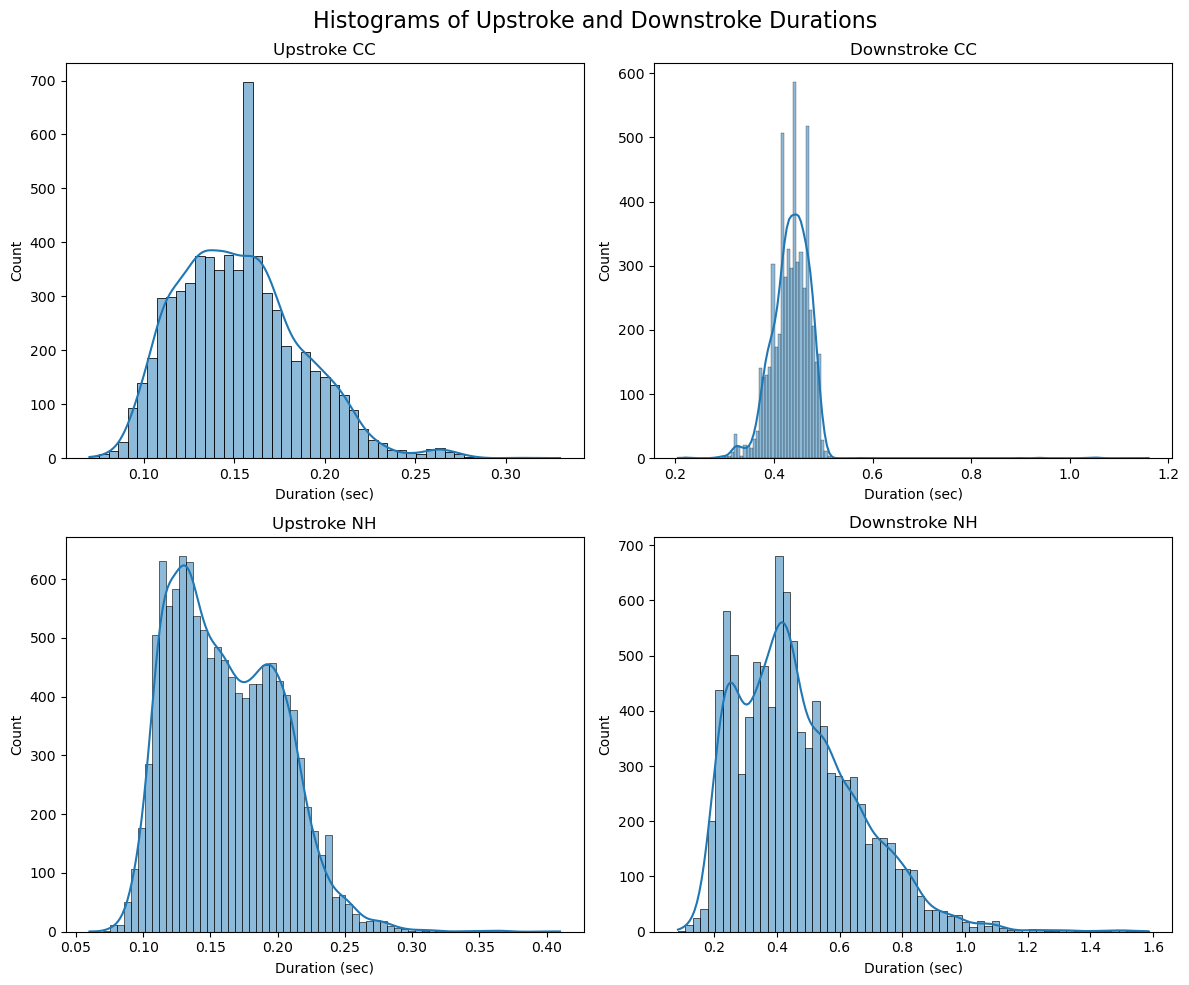

In [6]:
from my_plotting_fun import stroke_distributions , plot_upstroke_downstroke_histograms
upstroke_cc, downstroke_cc, df_strokse_cc = stroke_distributions(output_data[idx_cc], label_a=1, label_b=2, zero_label=0, signal_freq=200)
upstroke_nh, downstroke_nh, df_strokse_nh = stroke_distributions(output_data[idx_nh], label_a=3, label_b=4, zero_label=0, signal_freq=200)
plot_upstroke_downstroke_histograms(upstroke_cc, downstroke_cc, upstroke_nh, downstroke_nh)

Let's first make an LSTM that can estimate among the five output classes. Let's split the data once and keep it same between the various networks we test.

In [7]:
from mylstm_fun import build_lstm_windows
X , y = build_lstm_windows(input_data=input_data, output_data=output_data, window=120, stride=1, normalize=True)
from mylstm_fun import split_data_stratified
X_train, X_val, X_test, y_train, y_val, y_test = split_data_stratified(X, y, train_size=0.7, val_size=0.15, test_size=0.15)
from mylstm_fun import print_label_distribution
class_weights,weight_tensor=print_label_distribution(y_train, y_val, y_test, y)

c:\Users\Suranjan\miniconda3\envs\torch_cu13.0\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensorboard available
✅ Built LSTM windows: X (1910800, 120, 1), y (1910800,)
Label Distribution:
------------------------------
Train set:
    Label 0: 1153357
    Label 1: 38318
    Label 2: 31496
    Label 3: 57044
    Label 4: 57345

Validation set:
    Label 0: 247148
    Label 1: 8211
    Label 2: 6749
    Label 3: 12224
    Label 4: 12288

Test set:
    Label 0: 247148
    Label 1: 8211
    Label 2: 6750
    Label 3: 12223
    Label 4: 12288



Training without class weights first.

In [8]:
from mylstm_fun import train_lstm_classifier
# X_train, y_train: tensors or numpy arrays of shape (N, T, F) and (N,)
# X_val, y_val are optional
# !pip install tensorboard

model, hist = train_lstm_classifier(
    X_train, y_train,
    X_val=X_val, y_val=y_val,
    hidden_size=128,
    num_layers=2,
    dropout=0.2,
    bidirectional=False,
    batch_size=1024,
    epochs=100,
    lr=1e-3,
    patience=5,
    clip_norm=1.0,
    verbose=True,
    # class_weights=weight_tensor,
    tb_log_dir="runs"
)

# Evaluate on held-out test set
from mylstm_fun import evaluate_model
CLASS_LABELS = [
    "Nothing",
    "Diastolic (CC)",
    "Systolic (CC)",
    "Diastolic (NH)",
    "Systolic (NH)"
]

results = evaluate_model(model, X_test, y_test, label_names=CLASS_LABELS)

TensorBoard logging to runs


Epoch 001/100 - loss: 0.2413 - acc: 0.9103 - val_loss: 0.1717 - val_acc: 0.9264


Epoch 002/100 - loss: 0.1590 - acc: 0.9319 - val_loss: 0.1424 - val_acc: 0.9390


Epoch 003/100 - loss: 0.1436 - acc: 0.9383 - val_loss: 0.1315 - val_acc: 0.9437


Epoch 004/100 - loss: 0.1342 - acc: 0.9425 - val_loss: 0.1311 - val_acc: 0.9433


Epoch 005/100 - loss: 0.1275 - acc: 0.9453 - val_loss: 0.1267 - val_acc: 0.9444


Epoch 006/100 - loss: 0.1227 - acc: 0.9473 - val_loss: 0.1166 - val_acc: 0.9501


Epoch 007/100 - loss: 0.1191 - acc: 0.9486 - val_loss: 0.1120 - val_acc: 0.9519


Epoch 008/100 - loss: 0.1160 - acc: 0.9497 - val_loss: 0.1116 - val_acc: 0.9517


Epoch 009/100 - loss: 0.1134 - acc: 0.9510 - val_loss: 0.1086 - val_acc: 0.9526


Epoch 010/100 - loss: 0.1109 - acc: 0.9518 - val_loss: 0.1074 - val_acc: 0.9536


Epoch 011/100 - loss: 0.1087 - acc: 0.9527 - val_loss: 0.1078 - val_acc: 0.9530


Epoch 012/100 - loss: 0.1071 - acc: 0.9534 - val_loss: 0.1051 - val_acc: 0.9543


Epoch 013/100 - loss: 0.1051 - acc: 0.9543 - val_loss: 0.1022 - val_acc: 0.9553


Epoch 014/100 - loss: 0.1034 - acc: 0.9548 - val_loss: 0.0996 - val_acc: 0.9565


Epoch 015/100 - loss: 0.1021 - acc: 0.9553 - val_loss: 0.0992 - val_acc: 0.9566


Epoch 016/100 - loss: 0.1003 - acc: 0.9560 - val_loss: 0.0966 - val_acc: 0.9581


Epoch 017/100 - loss: 0.0991 - acc: 0.9566 - val_loss: 0.0983 - val_acc: 0.9573


Epoch 018/100 - loss: 0.0982 - acc: 0.9570 - val_loss: 0.0965 - val_acc: 0.9579


Epoch 019/100 - loss: 0.0968 - acc: 0.9575 - val_loss: 0.0958 - val_acc: 0.9576


Epoch 020/100 - loss: 0.0957 - acc: 0.9581 - val_loss: 0.0936 - val_acc: 0.9593


Epoch 021/100 - loss: 0.0945 - acc: 0.9586 - val_loss: 0.0943 - val_acc: 0.9587


Epoch 022/100 - loss: 0.0935 - acc: 0.9589 - val_loss: 0.0925 - val_acc: 0.9598


Epoch 023/100 - loss: 0.0923 - acc: 0.9594 - val_loss: 0.0928 - val_acc: 0.9594


Epoch 024/100 - loss: 0.0915 - acc: 0.9598 - val_loss: 0.0895 - val_acc: 0.9608


Epoch 025/100 - loss: 0.0905 - acc: 0.9602 - val_loss: 0.0907 - val_acc: 0.9605


Epoch 026/100 - loss: 0.0900 - acc: 0.9604 - val_loss: 0.0878 - val_acc: 0.9615


Epoch 027/100 - loss: 0.0886 - acc: 0.9610 - val_loss: 0.0922 - val_acc: 0.9601


Epoch 028/100 - loss: 0.0879 - acc: 0.9613 - val_loss: 0.0910 - val_acc: 0.9604


Epoch 029/100 - loss: 0.0870 - acc: 0.9617 - val_loss: 0.0879 - val_acc: 0.9615


Epoch 030/100 - loss: 0.0866 - acc: 0.9619 - val_loss: 0.0890 - val_acc: 0.9607


Epoch 031/100 - loss: 0.0855 - acc: 0.9623 - val_loss: 0.0872 - val_acc: 0.9618


Epoch 032/100 - loss: 0.0847 - acc: 0.9628 - val_loss: 0.0849 - val_acc: 0.9627


Epoch 033/100 - loss: 0.0842 - acc: 0.9628 - val_loss: 0.0841 - val_acc: 0.9629


Epoch 034/100 - loss: 0.0831 - acc: 0.9632 - val_loss: 0.0846 - val_acc: 0.9631


Epoch 035/100 - loss: 0.0824 - acc: 0.9638 - val_loss: 0.0831 - val_acc: 0.9637


Epoch 036/100 - loss: 0.0820 - acc: 0.9639 - val_loss: 0.0843 - val_acc: 0.9635


Epoch 037/100 - loss: 0.0816 - acc: 0.9640 - val_loss: 0.0828 - val_acc: 0.9638


Epoch 038/100 - loss: 0.0811 - acc: 0.9642 - val_loss: 0.0820 - val_acc: 0.9643


Epoch 039/100 - loss: 0.0803 - acc: 0.9647 - val_loss: 0.0820 - val_acc: 0.9641


Epoch 040/100 - loss: 0.0796 - acc: 0.9650 - val_loss: 0.0829 - val_acc: 0.9632


Epoch 041/100 - loss: 0.0789 - acc: 0.9655 - val_loss: 0.0803 - val_acc: 0.9646


Epoch 042/100 - loss: 0.0779 - acc: 0.9657 - val_loss: 0.0805 - val_acc: 0.9646


Epoch 043/100 - loss: 0.0777 - acc: 0.9659 - val_loss: 0.0829 - val_acc: 0.9638


Epoch 044/100 - loss: 0.0776 - acc: 0.9659 - val_loss: 0.0796 - val_acc: 0.9651


Epoch 045/100 - loss: 0.0766 - acc: 0.9663 - val_loss: 0.0784 - val_acc: 0.9656


Epoch 046/100 - loss: 0.0759 - acc: 0.9667 - val_loss: 0.0765 - val_acc: 0.9663


Epoch 047/100 - loss: 0.0759 - acc: 0.9666 - val_loss: 0.0773 - val_acc: 0.9663


Epoch 048/100 - loss: 0.0751 - acc: 0.9669 - val_loss: 0.0787 - val_acc: 0.9654


Epoch 049/100 - loss: 0.0751 - acc: 0.9671 - val_loss: 0.0782 - val_acc: 0.9657


Epoch 050/100 - loss: 0.0744 - acc: 0.9673 - val_loss: 0.0789 - val_acc: 0.9656


Epoch 051/100 - loss: 0.0741 - acc: 0.9674 - val_loss: 0.0799 - val_acc: 0.9649
Early stopping at epoch 51 (best val_loss=0.0765).

=== Test Results ===
Balanced Accuracy: 0.8973

Classification Report:
                precision    recall  f1-score   support

       Nothing     0.9778    0.9831    0.9805    247148
Diastolic (CC)     0.9143    0.9109    0.9126      8211
 Systolic (CC)     0.9744    0.9628    0.9686      6750
Diastolic (NH)     0.7543    0.6795    0.7149     12223
 Systolic (NH)     0.9514    0.9504    0.9509     12288

      accuracy                         0.9662    286620
     macro avg     0.9145    0.8973    0.9055    286620
  weighted avg     0.9653    0.9662    0.9657    286620



We can see the balanced accuracy is not great at 89.73%%. Now training with class weights.

In [ ]:
from mylstm_fun import train_lstm_classifier
# X_train, y_train: tensors or numpy arrays of shape (N, T, F) and (N,)
# X_val, y_val are optional

model, hist = train_lstm_classifier(
    X_train, y_train,
    X_val=X_val, y_val=y_val,
    hidden_size=128,
    num_layers=2,
    dropout=0.2,
    bidirectional=False,
    batch_size=1024,
    epochs=100,
    lr=1e-3,
    patience=5,
    clip_norm=1.0,
    verbose=True,
    class_weights=weight_tensor
)

# Evaluate on held-out test set
from mylstm_fun import evaluate_model
CLASS_LABELS = [
    "Nothing",
    "Diastolic (CC)",
    "Systolic (CC)",
    "Diastolic (NH)",
    "Systolic (NH)"
]

results = evaluate_model(model, X_test, y_test, label_names=CLASS_LABELS)

We can see the balanced accuracy has increased to ...

In [8]:
from mylstm_fun import train_cnnlstm_classifier
model_cnnlstm, hist_cnnlstm = train_cnnlstm_classifier(
    X_train, y_train,
    X_val=X_val, y_val=y_val,
    cnn_channels=(32, 64),
    kernel_size=5,
    pool_size=2,
    lstm_hidden=128,
    lstm_layers=2,
    dropout=0.2,
    bidirectional=False,
    batch_size=256,
    epochs=200,
    lr=1e-3,
    patience=5,
    clip_norm=1.0,
    verbose=True
)


Epoch 001/200 - loss: 0.1778 - acc: 0.9272 - val_loss: 0.1289 - val_acc: 0.9448


Epoch 002/200 - loss: 0.1309 - acc: 0.9434 - val_loss: 0.1168 - val_acc: 0.9500


Epoch 003/200 - loss: 0.1185 - acc: 0.9486 - val_loss: 0.1097 - val_acc: 0.9518


Epoch 004/200 - loss: 0.1108 - acc: 0.9519 - val_loss: 0.1051 - val_acc: 0.9537


Epoch 005/200 - loss: 0.1052 - acc: 0.9539 - val_loss: 0.0988 - val_acc: 0.9565


Epoch 006/200 - loss: 0.1009 - acc: 0.9557 - val_loss: 0.1015 - val_acc: 0.9553


Epoch 007/200 - loss: 0.0967 - acc: 0.9576 - val_loss: 0.0920 - val_acc: 0.9589


Epoch 008/200 - loss: 0.0933 - acc: 0.9589 - val_loss: 0.0895 - val_acc: 0.9604


Epoch 009/200 - loss: 0.0907 - acc: 0.9600 - val_loss: 0.0885 - val_acc: 0.9609


Epoch 010/200 - loss: 0.0881 - acc: 0.9613 - val_loss: 0.0851 - val_acc: 0.9626


Epoch 011/200 - loss: 0.0855 - acc: 0.9624 - val_loss: 0.0857 - val_acc: 0.9624


Epoch 012/200 - loss: 0.0836 - acc: 0.9632 - val_loss: 0.0826 - val_acc: 0.9637


Epoch 013/200 - loss: 0.0815 - acc: 0.9642 - val_loss: 0.0828 - val_acc: 0.9639


Epoch 014/200 - loss: 0.0797 - acc: 0.9651 - val_loss: 0.0816 - val_acc: 0.9639


Epoch 015/200 - loss: 0.0786 - acc: 0.9655 - val_loss: 0.0786 - val_acc: 0.9655


Epoch 016/200 - loss: 0.0769 - acc: 0.9665 - val_loss: 0.0775 - val_acc: 0.9660


Epoch 017/200 - loss: 0.0759 - acc: 0.9668 - val_loss: 0.0800 - val_acc: 0.9649


Epoch 018/200 - loss: 0.0743 - acc: 0.9675 - val_loss: 0.0784 - val_acc: 0.9657


Epoch 019/200 - loss: 0.0731 - acc: 0.9683 - val_loss: 0.0772 - val_acc: 0.9666


Epoch 020/200 - loss: 0.0721 - acc: 0.9684 - val_loss: 0.0754 - val_acc: 0.9672


Epoch 021/200 - loss: 0.0709 - acc: 0.9691 - val_loss: 0.0745 - val_acc: 0.9676


Epoch 022/200 - loss: 0.0704 - acc: 0.9693 - val_loss: 0.0728 - val_acc: 0.9681


Epoch 023/200 - loss: 0.0696 - acc: 0.9697 - val_loss: 0.0744 - val_acc: 0.9673


Epoch 024/200 - loss: 0.0685 - acc: 0.9703 - val_loss: 0.0741 - val_acc: 0.9675


Epoch 025/200 - loss: 0.0680 - acc: 0.9705 - val_loss: 0.0727 - val_acc: 0.9684


Epoch 026/200 - loss: 0.0670 - acc: 0.9707 - val_loss: 0.0707 - val_acc: 0.9695


Epoch 027/200 - loss: 0.0662 - acc: 0.9712 - val_loss: 0.0727 - val_acc: 0.9686


Epoch 028/200 - loss: 0.0657 - acc: 0.9715 - val_loss: 0.0714 - val_acc: 0.9691


KeyboardInterrupt: 

## Why a Nested (Cascaded) LSTM Architecture Can Improve Performance

The **key insight** motivating a cascaded LSTM design in this project is that the **temporal dynamics of the signal** — particularly the **upstroke and downstroke durations** — differ significantly between **chest compressions (CC)** and **normal heartbeats (NH)**.  
Attempting to force a single LSTM to generalize across both regimes leads to a model that compromises its temporal sensitivity, averaging out distinct timing characteristics.

---

### 🧠 1. Distinct Temporal Scales Between CC and NH

Statistical analysis of the waveform segments showed that:

- **Upstroke durations** (diastolic → systolic) and  
- **Downstroke durations** (systolic → diastolic)

are **systematically different** between **CC** and **NH**.  
This implies that each regime has its own rhythm and dynamics — effectively, *two separate time-series processes*.

A single LSTM trained on both may struggle to capture both sets of dynamics simultaneously:
- It must learn **fast**, short upstrokes typical of CC,  
  *and* **slower**, smoother patterns seen in NH.  
- Gradients from both types of sequences may conflict, causing the model to learn suboptimal shared representations.

---

### ⚙️ 2. Cascaded (Hierarchical) Structure

To handle this heterogeneity, the model is **split into a cascade of specialized LSTMs**:

1. **Stage 1 — Regime Classifier:**  
   A first LSTM predicts whether a given window belongs to a **CC** or **NH** regime.  
   - This acts as a *gating network*, selecting which specialized branch should process the sequence further.

2. **Stage 2 — Conditional Sub-models:**  
   Two additional LSTMs are trained separately:
   - One dedicated to **CC sequences**,  
   - Another for **NH sequences**.  
   Each sub-model then classifies its input into **“Nothing”, “Diastolic”, or “Systolic”** states.

This hierarchy allows each LSTM to specialize:
- The **CC model** learns fast, high-frequency transitions.
- The **NH model** learns slower, smoother cycles.

---

### 🎯 3. Benefits of the Cascaded Approach

| Advantage | Description |
|------------|--------------|
| **Specialization** | Each model focuses on one temporal regime, avoiding confusion between fundamentally different dynamics. |
| **Reduced interference** | Training gradients for CC and NH are decoupled — no cross-regime trade-offs. |
| **Improved interpretability** | Intermediate predictions (CC vs NH) provide a logical breakdown of the decision process. |
| **Better generalization** | Each sub-model can be smaller and better regularized, reducing overfitting while capturing relevant timing features. |
| **Scalability** | Additional regimes or signal types can be incorporated as new branches without retraining the entire system. |

---

### 🧩 4. Summary

Because the **temporal morphology** (upstroke/downstroke durations) is **intrinsically different** between CC and NH, a **nested cascaded LSTM** — with a regime classifier followed by regime-specific sub-models — is a more physiologically faithful and statistically robust design.  
It preserves sensitivity to the dynamics within each mode while maintaining a clean decision structure between modes.


Now trying with a cascaded LSTM. First LSTM is a binary classifier to decide whether CC or NH

Let's construct the Dataset first

In [41]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import TensorDataset, DataLoader
input_data_binary_stage = input_data[idx_cc+idx_nh,:]
# Create the base array first
base_array = np.concatenate([np.zeros(len(idx_cc)), np.ones(len(idx_nh))])
# Then repeat along axis 1
output_data_binary_stage = np.repeat(base_array.reshape(-1, 1), input_data_binary_stage.shape[1], axis=1)


WINDOW = 100       # timesteps per window
STRIDE = 1        # slide within each 400-sample patch

# input_data: shape (6800, 400), float
# output_data: shape (6800, 400), ints in {0..4}

# ----------------------------
# Build windows per patch (no cross-boundary windows)
# ----------------------------
Xs, ys = [], []
for x_row, y_row in zip(input_data_binary_stage, output_data_binary_stage.astype(int)):
    # (optional) per-patch normalization
    x = x_row.astype(np.float32)
    x = (x - x.mean()) / (x.std() + 1e-8)

    # make windows inside this 400-sample patch
    idx = np.arange(0, x.shape[0] - WINDOW + 1, STRIDE, dtype=np.int32)
    if idx.size == 0:
        continue
    # windows: (num_win, WINDOW), labels aligned to the last sample of each window
    X_row = np.stack([x[i:i+WINDOW] for i in idx], axis=0)[..., None]  # add feature dim -> (num_win, WINDOW, 1)
    y_row = y_row[idx + WINDOW - 1]

    Xs.append(X_row)
    ys.append(y_row)

X_bin = np.concatenate(Xs, axis=0)
y_bin = np.concatenate(ys, axis=0).astype(np.int64)

print("X shape:", X_bin.shape, "y shape:", y_bin.shape)


X shape: (1957403, 100, 1) y shape: (1957403,)


In [43]:
# ----------------------------
# 1) Stratified 80/10/10 split
# ----------------------------
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(sss1.split(X_bin, y_bin))
X_train_val, X_test = X_bin[train_val_idx], X_bin[test_idx]
y_train_val, y_test = y_bin[train_val_idx], y_bin[test_idx]

# Now split 10% val out of remaining 80% → 80/10/10 overall
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.1111, random_state=42)
train_idx, val_idx = next(sss2.split(X_train_val, y_train_val))
X_train, y_train = X_train_val[train_idx], y_train_val[train_idx]
X_val,   y_val   = X_train_val[val_idx],  y_train_val[val_idx]

print(f"Splits — train:{len(X_train)} val:{len(X_val)} test:{len(X_test)}")

# ----------------------------
# 2) Torch tensors & loaders (batched)
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).long()
X_val_t   = torch.from_numpy(X_val).float()
y_val_t   = torch.from_numpy(y_val).long()
X_test_t  = torch.from_numpy(X_test).float()
y_test_t  = torch.from_numpy(y_test).long()

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

BATCH = 4096  # feel free to raise this on your 5090 until near OOM
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  pin_memory=True, num_workers=8)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, pin_memory=True, num_workers=8)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, pin_memory=True, num_workers=8)

# ----------------------------
# 3) Binary LSTM model (2 logits → CE loss with labels 0/1)
# ----------------------------
class BinaryLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=1, dropout1=0.3, dropout2=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout1 if num_layers > 1 else 0.0
        )
        self.dropout1 = nn.Dropout(dropout1)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout2)
        self.fc_out = nn.Linear(64, 2)  # two logits for CE

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        x = self.dropout1(h_n[-1])
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        return self.fc_out(x)

model = BinaryLSTM(input_size=1, hidden_size=128, num_layers=2).to(device)
criterion = nn.CrossEntropyLoss()

# Optional: handle imbalance with class weights
# w0, w1 = (len(y_train) / (2*np.bincount(y_train)))
# criterion = nn.CrossEntropyLoss(weight=torch.tensor([w0, w1], dtype=torch.float32, device=device))

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ----------------------------
# 4) Train / eval + EARLY STOPPING on val loss
# ----------------------------
@torch.no_grad()
def eval_epoch(model, loader):
    model.eval()
    tot_loss=tot_correct=tot=0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True); yb = yb.to(device, non_blocking=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        tot_loss += loss.item() * xb.size(0)
        tot_correct += (logits.argmax(1) == yb).sum().item()
        tot += xb.size(0)
    return tot_loss/tot, tot_correct/tot

def train_epoch(model, loader):
    model.train()
    tot_loss=tot_correct=tot=0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True); yb = yb.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        tot_loss += loss.item() * xb.size(0)
        tot_correct += (logits.argmax(1) == yb).sum().item()
        tot += xb.size(0)
    return tot_loss/tot, tot_correct/tot

num_epochs = 100
patience   = 5
min_delta  = 1e-4
best_val   = float('inf')
no_imp     = 0
best_state = None

for ep in range(1, num_epochs+1):
    tr_loss, tr_acc = train_epoch(model, train_loader)
    va_loss, va_acc = eval_epoch(model, val_loader)
    print(f"Epoch {ep:02d} | train {tr_loss:.4f}/{tr_acc:.4f} | val {va_loss:.4f}/{va_acc:.4f}")
    if va_loss + min_delta < best_val:
        best_val = va_loss; no_imp = 0
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    else:
        no_imp += 1
        if no_imp >= patience:
            print(f"Early stopping at epoch {ep}. Best val_loss={best_val:.4f}")
            break

if best_state:
    model.load_state_dict(best_state)
    model.to(device)
    print("Restored best model weights.")

# ----------------------------
# 5) Final test
# ----------------------------
test_loss, test_acc = eval_epoch(model, test_loader)
print(f"TEST — loss {test_loss:.4f}, acc {test_acc:.4f}")

# ----------------------------
# 6) Inference helper (probability of class=1)
# ----------------------------
import torch.nn.functional as F

@torch.no_grad()
def predict_proba_binary(X_np):
    model.eval()
    Xt = torch.from_numpy(X_np).float().to(device)
    logits = model(Xt)
    probs = F.softmax(logits, dim=1)[:, 1]
    return probs.detach().cpu().numpy()

Splits — train:1391948 val:173974 test:391481
Using device: cuda
Epoch 01 | train 0.5990/0.6833 | val 0.4759/0.7871
Epoch 02 | train 0.3688/0.8293 | val 0.1553/0.9411
Epoch 03 | train 0.1161/0.9588 | val 0.0829/0.9706
Epoch 04 | train 0.0688/0.9763 | val 0.0544/0.9808
Epoch 05 | train 0.0485/0.9838 | val 0.0376/0.9874
Epoch 06 | train 0.0388/0.9871 | val 0.0311/0.9894
Epoch 07 | train 0.0329/0.9891 | val 0.0292/0.9901
Epoch 08 | train 0.0271/0.9909 | val 0.0233/0.9918
Epoch 09 | train 0.0234/0.9920 | val 0.0219/0.9926
Epoch 10 | train 0.0203/0.9931 | val 0.0165/0.9943
Epoch 11 | train 0.0191/0.9934 | val 0.0142/0.9951
Epoch 12 | train 0.0161/0.9945 | val 0.0134/0.9954
Epoch 13 | train 0.0143/0.9951 | val 0.0149/0.9950
Epoch 14 | train 0.0132/0.9954 | val 0.0105/0.9961
Epoch 15 | train 0.0122/0.9958 | val 0.0103/0.9962
Epoch 16 | train 0.0113/0.9960 | val 0.0096/0.9963
Epoch 17 | train 0.0100/0.9964 | val 0.0085/0.9968
Epoch 18 | train 0.0095/0.9966 | val 0.0078/0.9971
Epoch 19 | train 

Now let's train the 3 way classifier i.e. nothing, diastolic, systolic, corresponding to chest compression LSTM in the 2nd stage.

In [ ]:
from mylstm_fun import build_lstm_windows
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# input_data: (6800, 400), output_data: (6800, 400)
X, y = build_lstm_windows(input_data[idx_cc], output_data[idx_cc], window=100, stride=1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Stratified 80/10/10 split ---
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(sss.split(X, y))

X_train_val, X_test = X[train_val_idx], X[test_idx]
y_train_val, y_test = y[train_val_idx], y[test_idx]

# Split remaining 20% (val) from train_val (80%)
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.1111, random_state=42)
# 0.1111 of 0.9 ≈ 0.1 → gives 80/10/10 overall
train_idx, val_idx = next(sss_val.split(X_train_val, y_train_val))

X_train, y_train = X_train_val[train_idx], y_train_val[train_idx]
X_val,   y_val   = X_train_val[val_idx],   y_train_val[val_idx]

# --- Convert to torch tensors ---
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).long()
X_val_t   = torch.from_numpy(X_val).float()
y_val_t   = torch.from_numpy(y_val).long()
X_test_t  = torch.from_numpy(X_test).float()
y_test_t  = torch.from_numpy(y_test).long()

# --- Dataset & DataLoader ---
train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True,  pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, pin_memory=True)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")


# --- Model ---
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout1=0.3, dropout2=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout1 if num_layers > 1 else 0.0
        )
        self.dropout1 = nn.Dropout(dropout1)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout2)
        self.fc_out = nn.Linear(64, num_classes)

    def forward(self, x):
        out_seq, (h_n, c_n) = self.lstm(x)
        h_last = h_n[-1]
        x = self.dropout1(h_last)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout2(x)
        return self.fc_out(x)

model = LSTMClassifier(input_size=1, hidden_size=256, num_layers=2, num_classes=len(np.unique(y))).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# --- Train / Eval helpers ---
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    tot_loss = tot_correct = tot_samples = 0
    for xb, yb in loader:
        xb = xb.to(device); yb = yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        tot_loss += loss.item() * xb.size(0)
        tot_correct += (logits.argmax(1) == yb).sum().item()
        tot_samples += xb.size(0)
    return tot_loss / tot_samples, tot_correct / tot_samples

def eval_epoch(model, loader, criterion):
    model.eval()
    tot_loss = tot_correct = tot_samples = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device); yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            tot_loss += loss.item() * xb.size(0)
            tot_correct += (logits.argmax(1) == yb).sum().item()
            tot_samples += xb.size(0)
    return tot_loss / tot_samples, tot_correct / tot_samples

# --- Train (train/val) ---
num_epochs = 15
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc     = eval_epoch(model, val_loader, criterion)
    print(f"Epoch {epoch:2d} — train_loss {train_loss:.4f}, acc {train_acc:.4f} | val_loss {val_loss:.4f}, acc {val_acc:.4f}")

# --- Final TEST evaluation (10% held-out) ---
test_loss, test_acc = eval_epoch(model, test_loader, criterion)
print(f"TEST — loss {test_loss:.4f}, acc {test_acc:.4f}")

Freeze requirements for reproducibility

In [ ]:
!pip freeze > requirements.txt
